In [1]:
import pyspark, pickle
from pyspark import SparkContext
from pyspark.sql.functions import countDistinct
from pyspark.storagelevel import StorageLevel
import pandas as pd
import numpy as np

from pyspark.ml.feature import CountVectorizer, StringIndexer, StopWordsRemover, NGram, RegexTokenizer

from nltk.corpus import stopwords
import nltk, re

from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline

from pyspark.sql.types import StringType

# from sklearn import svm, grid_search, datasets
# from spark_sklearn import GridSearchCV
from sklearn.model_selection import GridSearchCV
pd.options.display.max_colwidth = -1

<ipython-input-1-3ef3e947392d>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1


In [2]:
# d_df = pickle.load( open('d_df.pkl', "rb" ) )
b_df = pickle.load( open('b_df.pkl', "rb" ) )
# after_df = pickle.load( open('after_df.pkl', "rb" ) )
# d_tweets = pickle.load( open('d_tweets.pkl', "rb" ) )
for i, tweet in enumerate(b_df['tweet']):
    b_df['tweet'].iloc[i] = tweet.rsplit(' ', 1)[0]

/Users/SirLawrenceKatz/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
cv1 = CountVectorizer(stop_words='english')

X_cv1 = cv1.fit_transform(M['tokenized_tweets'])
cv_norm = normalize(X_cv1)
cv_array = cv_norm.toarray()
pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names()).head()

In [3]:
b_df

,created_at,date,time,timezone,user_id,username,name,tweet,language,mentions,urls,retweets_count,hashtags,cashtags,link,reply_to,translate
0,2017-09-28 16:59:58 PDT,2017-09-28,16:59:58,-800,3875558114,mtg72252,MrMtg83,nunyagator jbingainesville coachmcelwain wadedukes fun and gun left with spurrier move on that s why he is one of the best coaches sadly he is retired lol gogators,en,[],[],0,['gogators'],[],https://twitter.com/MTG72252/status/913553904230633474,"[{'screen_name': 'nunyaGator', 'name': 'nunya', 'id': '381674479'}, {'screen_name': 'CoachMcElwain', 'name': 'Jim McElwain', 'id': '436237812'}, {'screen_name': 'WadeDukes', 'name': 'Wade Dukes', 'id': '805001388'}]",NaN
1,2017-09-28 16:59:57 PDT,2017-09-28,16:59:57,-800,779227123777204224,fireboltstudio,GothicJawa™,them dont jump the gun me so a server with log and account creation with hased passwords gamedev projectrestaurant https t co,en,[],[],3,"['gamedev', 'unity3d', 'projectrestaurant']",[],https://twitter.com/FireBoltStudio/status/913553902221582336,[],NaN
3,2017-09-28 16:59:49 PDT,2017-09-28,16:59:49,-800,50424317,niveanotes,stephanie 🇺🇸,time tell me again how guns save lives,en,[],[],0,[],[],https://twitter.com/NiveaNotes/status/913553866175713285,"[{'screen_name': 'TIME', 'name': 'TIME', 'id': '14293310'}]",NaN
5,2017-09-28 16:59:40 PDT,2017-09-28,16:59:40,-800,252266408,bear_faced_lady,Bearnevolent Dictator,i kill this in a good way on karaoke honestly here’s a song for you… sweet child o mine by guns n roses https t co,en,[],['https://open.spotify.com/track/7o2CTH4ctstm8TNelqjb51?context=spotify%3Auser%3Aspotify%3Aplaylist%3A37i9dQZF1E51v0vXfMdhpJ'],0,[],[],https://twitter.com/bear_faced_lady/status/913553827873398785,[],NaN
6,2017-09-28 16:59:36 PDT,2017-09-28,16:59:36,-800,2390426474,yung_berg21,Zach Bergman,road rage incident dude just said he was gone pull a gun on me so i grabbed my pit out the car and he jumped back in his car,en,[],[],0,[],[],https://twitter.com/Yung_Berg21/status/913553813616726016,[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445105,2017-09-25 11:42:20 PDT,2017-09-25,11:42:20,-800,2291542513,atheistbhakt,कलम वाली बाईं,wolveruddin f muslim massacre u say us sold guns blah blah all other mistake but wat bout jehadi mauling ppl n streets,en,[],[],0,[],[],https://twitter.com/atheistbhakt/status/912386807425200128,"[{'screen_name': 'wolveruddin', 'name': 'Aryan Salgaonkar', 'id': '86708477'}]",NaN
445106,2017-09-25 11:42:08 PDT,2017-09-25,11:42:08,-800,763603060702769152,jaclyncwhite,Jaclyn White,warriors for the gods dairies machine gun molly is now available on amazon kindle direct publishing https t co,en,[],[],0,[],[],https://twitter.com/JaclynCWhite/status/912386755403374592,[],NaN
445107,2017-09-25 11:42:08 PDT,2017-09-25,11:42:08,-800,813831733258964993,musesofsteele,Jenaé thee Music Attorney,dacialynnx you can target who you want but that dress is like a machine gun lol everyone is getting,en,[],[],0,[],[],https://twitter.com/musesofsteele/status/912386754019250177,"[{'screen_name': 'dacialynnx', 'name': 'dacia 🤘🏽', 'id': '776281526266892288'}]",NaN
445108,2017-09-25 11:42:06 PDT,2017-09-25,11:42:06,-800,4106736316,justicebeat2day,The Justice Beat Talk/Radio Show,alabama teen shot after police mistake saxophone for machine gun https t co via,en,"[{'screen_name': 'thingsuthinku', 'name': 'thingsuthink', 'id': '4911389110'}]",['http://thingsuthink.com/comedy/alabama-teen-shot-after-police-mistake-saxophone-for-machine-gun/'],0,[],[],https://twitter.com/JusticeBeat2Day/status/912386745802657793,[],NaN


In [6]:
#removing bots by eliminating duplicates
nd_tweets = list(set(b_df['tweet']))
len(nd_tweets)
nd_tweets

['',
 'friends left these messages for the   y o who shot a federal agent and turned gun on himself  at     the gunman s family on the incident   https   t co ',
 'shoulda just threw a jump ball if u was gun do that',
 'jesse holding two different guns to my head  listen one is less bad but it still kills',
 '   he probably should have shot the sob  had he had his gun w  him  he wouldn t have had   run to his car  would have been self defense',
 'guns n roses no rock in rio     patience   https   t co esmcpxcaek via ',
 ' donaldjtrumpjr hey don  when you get a chance  let us know when was the last time the  nfl or  nflpa repudiated  gangs  again gangs  not guns',
 'best part of tombstone is when doc holliday imitates johnny ringo with a cup instead of the gun ',
 ' ughreallykate  wyldeheartedson  cnn the gunman was stopped by a man with a gun in his car   this is a hate crime and should be a civil rights case  black on white crime',
 '    iameuropa   wsocfash  richardbspencer they shou

In [4]:
b_df

,created_at,date,time,timezone,user_id,username,name,tweet,language,mentions,urls,retweets_count,hashtags,cashtags,link,reply_to,translate
0,2017-09-28 16:59:58 PDT,2017-09-28,16:59:58,-800,3875558114,mtg72252,MrMtg83,nunyagator jbingainesville coachmcelwain wadedukes fun and gun left with spurrier move on that s why he is one of the best coaches sadly he is retired lol gogators,en,[],[],0,['gogators'],[],https://twitter.com/MTG72252/status/913553904230633474,"[{'screen_name': 'nunyaGator', 'name': 'nunya', 'id': '381674479'}, {'screen_name': 'CoachMcElwain', 'name': 'Jim McElwain', 'id': '436237812'}, {'screen_name': 'WadeDukes', 'name': 'Wade Dukes', 'id': '805001388'}]",NaN
1,2017-09-28 16:59:57 PDT,2017-09-28,16:59:57,-800,779227123777204224,fireboltstudio,GothicJawa™,them dont jump the gun me so a server with log and account creation with hased passwords gamedev projectrestaurant https t co,en,[],[],3,"['gamedev', 'unity3d', 'projectrestaurant']",[],https://twitter.com/FireBoltStudio/status/913553902221582336,[],NaN
3,2017-09-28 16:59:49 PDT,2017-09-28,16:59:49,-800,50424317,niveanotes,stephanie 🇺🇸,time tell me again how guns save lives,en,[],[],0,[],[],https://twitter.com/NiveaNotes/status/913553866175713285,"[{'screen_name': 'TIME', 'name': 'TIME', 'id': '14293310'}]",NaN
5,2017-09-28 16:59:40 PDT,2017-09-28,16:59:40,-800,252266408,bear_faced_lady,Bearnevolent Dictator,i kill this in a good way on karaoke honestly here’s a song for you… sweet child o mine by guns n roses https t co,en,[],['https://open.spotify.com/track/7o2CTH4ctstm8TNelqjb51?context=spotify%3Auser%3Aspotify%3Aplaylist%3A37i9dQZF1E51v0vXfMdhpJ'],0,[],[],https://twitter.com/bear_faced_lady/status/913553827873398785,[],NaN
6,2017-09-28 16:59:36 PDT,2017-09-28,16:59:36,-800,2390426474,yung_berg21,Zach Bergman,road rage incident dude just said he was gone pull a gun on me so i grabbed my pit out the car and he jumped back in his car 😂😂🤔,en,[],[],0,[],[],https://twitter.com/Yung_Berg21/status/913553813616726016,[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445105,2017-09-25 11:42:20 PDT,2017-09-25,11:42:20,-800,2291542513,atheistbhakt,कलम वाली बाईं,wolveruddin f muslim massacre u say us sold guns blah blah all other mistake but wat bout jehadi mauling ppl n streets,en,[],[],0,[],[],https://twitter.com/atheistbhakt/status/912386807425200128,"[{'screen_name': 'wolveruddin', 'name': 'Aryan Salgaonkar', 'id': '86708477'}]",NaN
445106,2017-09-25 11:42:08 PDT,2017-09-25,11:42:08,-800,763603060702769152,jaclyncwhite,Jaclyn White,warriors for the gods dairies machine gun molly is now available on amazon kindle direct publishing https t co,en,[],[],0,[],[],https://twitter.com/JaclynCWhite/status/912386755403374592,[],NaN
445107,2017-09-25 11:42:08 PDT,2017-09-25,11:42:08,-800,813831733258964993,musesofsteele,Jenaé thee Music Attorney,dacialynnx you can target who you want but that dress is like a machine gun lol everyone is getting shot,en,[],[],0,[],[],https://twitter.com/musesofsteele/status/912386754019250177,"[{'screen_name': 'dacialynnx', 'name': 'dacia 🤘🏽', 'id': '776281526266892288'}]",NaN
445108,2017-09-25 11:42:06 PDT,2017-09-25,11:42:06,-800,4106736316,justicebeat2day,The Justice Beat Talk/Radio Show,alabama teen shot after police mistake saxophone for machine gun https t co via thingsuthinku,en,"[{'screen_name': 'thingsuthinku', 'name': 'thingsuthink', 'id': '4911389110'}]",['http://thingsuthink.com/comedy/alabama-teen-shot-after-police-mistake-saxophone-for-machine-gun/'],0,[],[],https://twitter.com/JusticeBeat2Day/status/912386745802657793,[],NaN


In [4]:
d_tweets = b_df[['username','tweet', 'date','timezone']].copy()
d_tweets

,username,tweet,date,timezone
0,mtg72252,nunyagator jbingainesville coachmcelwain wadedukes fun and gun left with spurrier move on that s why he is one of the best coaches sadly he is retired lol gogators,2017-09-28,-800
1,fireboltstudio,them dont jump the gun me so a server with log and account creation with hased passwords gamedev projectrestaurant https t co,2017-09-28,-800
3,niveanotes,time tell me again how guns save lives,2017-09-28,-800
5,bear_faced_lady,i kill this in a good way on karaoke honestly here’s a song for you… sweet child o mine by guns n roses https t co,2017-09-28,-800
6,yung_berg21,road rage incident dude just said he was gone pull a gun on me so i grabbed my pit out the car and he jumped back in his car,2017-09-28,-800
...,...,...,...,...
445105,atheistbhakt,wolveruddin f muslim massacre u say us sold guns blah blah all other mistake but wat bout jehadi mauling ppl n streets,2017-09-25,-800
445106,jaclyncwhite,warriors for the gods dairies machine gun molly is now available on amazon kindle direct publishing https t co,2017-09-25,-800
445107,musesofsteele,dacialynnx you can target who you want but that dress is like a machine gun lol everyone is getting,2017-09-25,-800
445108,justicebeat2day,alabama teen shot after police mistake saxophone for machine gun https t co via,2017-09-25,-800


In [5]:
d_tweets.tweet = d_tweets.tweet.str.replace('https?://[^ ,]+', '[link]') #replace links with '[link]'d

In [6]:
d_tweets = d_tweets[d_tweets.tweet != '[link]']

In [7]:
d_tweets.shape
d_tweets.iloc[3]['tweet']
d_tweets

,username,tweet,date,timezone
0,mtg72252,nunyagator jbingainesville coachmcelwain wadedukes fun and gun left with spurrier move on that s why he is one of the best coaches sadly he is retired lol gogators,2017-09-28,-800
1,fireboltstudio,them dont jump the gun me so a server with log and account creation with hased passwords gamedev projectrestaurant https t co,2017-09-28,-800
3,niveanotes,time tell me again how guns save lives,2017-09-28,-800
5,bear_faced_lady,i kill this in a good way on karaoke honestly here’s a song for you… sweet child o mine by guns n roses https t co,2017-09-28,-800
6,yung_berg21,road rage incident dude just said he was gone pull a gun on me so i grabbed my pit out the car and he jumped back in his car,2017-09-28,-800
...,...,...,...,...
445105,atheistbhakt,wolveruddin f muslim massacre u say us sold guns blah blah all other mistake but wat bout jehadi mauling ppl n streets,2017-09-25,-800
445106,jaclyncwhite,warriors for the gods dairies machine gun molly is now available on amazon kindle direct publishing https t co,2017-09-25,-800
445107,musesofsteele,dacialynnx you can target who you want but that dress is like a machine gun lol everyone is getting,2017-09-25,-800
445108,justicebeat2day,alabama teen shot after police mistake saxophone for machine gun https t co via,2017-09-25,-800


In [81]:

# spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [11]:

# # Create spark dataframe of tweets called 'tweets spark'

# tweet_sp = spark.createDataFrame(d_tweets)
# tweet_sp.persist()
# tweet_sp.show()


In [10]:
# (train, test) = tweet_sp.randomSplit([0.7, 0.3], seed = 100)

# train.persist()
# test.persist()

# print(train.count())
# print(test.count())
# d_tweets.iloc[2]['tweet']

In [8]:

# Create regex tokenizer that is useful for Twitter data (preserves emoticons, hashtags, etc.)
# I used code from here, with some modifications: https://github.com/adonoho/TweetTokenizers/blob/master/PottsTweetTokenizer.py

# I got rid of ellipsis matcher
# I modified words with apostrophes to not keep after the apostrophe
# I got rid of the 'everything else that isn't whitespace' matcher
# I added regex to capture words in quotes as separate items: r'(?:["\'][a-zA-Z0-9/-]+["\'])'
pattern = r"""(?:\[link\])|(?:(?:\+?[01][\-\s.]*)?(?:[\(]?\d{3}[\-\s.\)]*)?\d{3}[\-\s.]*\d{4})|(?:(?<= )[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)|(<[^>]+>)|(?:@[\w_]+)|(?:\#+[\w_]+[\w\'_\-]*[\w_]+)|(?:["\'][a-z0-9/-]+["\'])|(?:[a-z][a-z\-_]+[a-z])|(?:[+\-]?\d+[,/.:-]\d+[+\-]?)|(?:[\w_]+)"""

word_re = re.compile(pattern, re.VERBOSE | re.I | re.UNICODE)


In [12]:
# df = spark.createDataFrame([d_tweets.iloc[2]['tweet'], d_tweets.iloc[5]['tweet']],
#                            StringType())
# df.show()

In [13]:
# RegexTokenizer(inputCol="value", outputCol="tokens", gaps=False, pattern=word_re.pattern).transform(df).take(2)

In [21]:
# import nltk
# nltk.download('stopwords')
# # Number my labels
# # Label numbering goes in order of most frequent label, descending
# label_indxr = StringIndexer(inputCol="existence", outputCol="label")

# # Tokenize tweets
# tokenizer = RegexTokenizer(inputCol="tweet", outputCol="tokens", gaps=False, pattern=word_re.pattern)

# # Remove stopwords
# stp_rmv = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='new_tokens',
#                            stopWords=stopwords.words('english'))

# # Ngrams
# ngram = NGram(inputCol=stp_rmv.getOutputCol(), outputCol="ngrams")

# # Count occurences of words
# cnvk = CountVectorizer(inputCol=ngram.getOutputCol(), outputCol='counts')

# # Train a NaiveBayes model
# nb = NaiveBayes(featuresCol=cnvk.getOutputCol(), modelType="multinomial")

# # Pipeline
# pipeline = Pipeline(stages=[label_indxr, tokenizer, stp_rmv, ngram, cnvk, nb])

# # Create evaluator
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
#                                              metricName="accuracy")
# # evaluator = BinaryClassificationEvaluator(labelCol='label',
# #                                         rawPredictionCol='prediction',
# #                                         metricName='areaUnderROC')

# # Program search params
# param_grid = (ParamGridBuilder() 
#     .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
#     .addGrid(ngram.n, [1, 2, 3]) \
#     .build())

# # Put pipeline together with param search
# cv_pipe = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SirLawrenceKatz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:

# Number my labels
# # Label numbering goes in order of most frequent label, descending
# label_indxr_svm = StringIndexer(inputCol="existence", outputCol="label")

# # Tokenize tweets
# tokenizer_svm = RegexTokenizer(inputCol="tweet", outputCol="tokens", gaps=False, pattern=word_re.pattern)

# # Remove stopwords
# stp_rmv_svm = StopWordsRemover(inputCol=tokenizer_svm.getOutputCol(), outputCol='new_tokens',
#                            stopWords=stopwords.words('english'))

# # Count occurences of words
# cnvk_svm = CountVectorizer(inputCol=stp_rmv_svm.getOutputCol(), outputCol='counts')

# # Pipeline
# pipeline_svm = Pipeline(stages=[label_indxr_svm, tokenizer_svm, stp_rmv_svm, cnvk_svm])

# # Create evaluator
# evaluator_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
#                                              metricName="f1")

In [68]:

# # Count Vectorize my data
# countvec_data_svm = pipeline_svm.fit(train).transform(train)
# countvec_data_svm.show()

In [9]:
# clean = filtration(d_tweets, "content")
dict_d_tweets = d_tweets.to_dict('list')
# dict_d_tweets

In [10]:
dict_d_tweets2 = dict_d_tweets['tweet']
dict_d_tweets2[:5]

[' nunyagator  jbingainesville     coachmcelwain  wadedukes fun and gun  left with spurrier  move on  that s why he is one of the best coaches  sadly he is retired lol   gogators',
 'them   dont jump the gun   me   so  a server with log and account creation with hased passwords    gamedev     projectrestaurant  https   t co ',
 ' time tell me again how guns save lives',
 'i kill this in a good way on karaoke  honestly    here’s a song for you… sweet child o  mine by guns n  roses  https   t co ',
 'road rage incident dude just said he was gone pull a gun on me so i grabbed my pit out the car and he jumped back in his car']

In [11]:

import spacy
import nltk
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim
from collections import Counter
from gensim.corpora.dictionary import Dictionary
nlp = spacy.load('en_core_web_sm')

In [12]:
tokenized_tweets = []
for tweet in dict_d_tweets2:
    tokenized_tweet = nlp(tweet)
    
    tweet = "" # we want to keep each tweet seperate
    
    for token in tokenized_tweet:
        if token.is_space:
            continue
        elif token.is_punct:
            continue
        elif token.is_stop:
            continue
        elif token.is_digit:
            continue
        elif len(token) == 1:
            continue
        elif len(token) == 2:
            continue
        else:
            tweet += str(token.lemma_) + " " #creating lemmatized version of tweet
        
    tokenized_tweets.append(tweet)
tokenized_tweets = list(map(str.strip, tokenized_tweets)) # strip whitespace
# tokenized_tweets = [x for x in tokenized_tweets if x != ""] # remove empty entries

In [16]:

len(tokenized_tweets)

310642

In [17]:
dict_d_tweets['tokenized_tweets'] = tokenized_tweets

dict_d_tweets_df = pd.DataFrame.from_dict(dict_d_tweets, orient='index')

In [39]:
tok_df1 = dict_d_tweets_df.T
tok_df1.notnull().tail()


# tok_df1['tweet']
tok_df1

,username,tweet,date,timezone,tokenized_tweets
0,mtg72252,nunyagator jbingainesville coachmcelwain wadedukes fun and gun left with spurrier move on that s why he is one of the best coaches sadly he is retired lol gogators,2017-09-28,-800,nunyagator jbingainesville coachmcelwain wadeduke fun gun leave spurri good coach sadly retire lol gogator
1,fireboltstudio,them dont jump the gun me so a server with log and account creation with hased passwords gamedev projectrestaurant https t co,2017-09-28,-800,jump gun server log account creation hase password gamedev projectrestaurant https
2,niveanotes,time tell me again how guns save lives,2017-09-28,-800,time tell gun save life
3,bear_faced_lady,i kill this in a good way on karaoke honestly here’s a song for you… sweet child o mine by guns n roses https t co,2017-09-28,-800,kill good way karaoke honestly song sweet child gun rose https
4,yung_berg21,road rage incident dude just said he was gone pull a gun on me so i grabbed my pit out the car and he jumped back in his car,2017-09-28,-800,road rage incident dude say go pull gun grab pit car jump car
...,...,...,...,...,...
310637,atheistbhakt,wolveruddin f muslim massacre u say us sold guns blah blah all other mistake but wat bout jehadi mauling ppl n streets,2017-09-25,-800,wolveruddin muslim massacre sell gun blah blah mistake wat bout jehadi mauling ppl street
310638,jaclyncwhite,warriors for the gods dairies machine gun molly is now available on amazon kindle direct publishing https t co,2017-09-25,-800,warrior god dairy machine gun molly available amazon kindle direct publishing https
310639,musesofsteele,dacialynnx you can target who you want but that dress is like a machine gun lol everyone is getting,2017-09-25,-800,dacialynnx target want dress like machine gun lol get
310640,justicebeat2day,alabama teen shot after police mistake saxophone for machine gun https t co via,2017-09-25,-800,alabama teen shot police mistake saxophone machine gun https


In [40]:
# Create count vectorizer on all reviews not counting rare words/misspellings or extremely common, such as "coffee"
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
sw = stopwords.words("english")
sw = sw + ['gun', 'guns', 'guns n roses', 'http', 'https']
vectorizer = CountVectorizer(min_df=10, stop_words = sw)
doc_word = vectorizer.fit_transform(tok_df1['tokenized_tweets'].str.replace(r'\d+','',regex=True))



/Users/SirLawrenceKatz/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['roses'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [41]:
# Create TF-IDF matrix for full corpus from tweets
from sklearn.feature_extraction.text import TfidfVectorizer
fulltfidf = TfidfVectorizer(min_df=10, stop_words = sw)
tfidf_full = fulltfidf.fit_transform(tok_df1['tokenized_tweets'].str.replace(r'\d+','',regex=True))


In [42]:
tfidf_full

<310642x15416 sparse matrix of type '<class 'numpy.float64'>'
	with 2109039 stored elements in Compressed Sparse Row format>

In [18]:
with open('Before_tfidf_vec.pickle', 'wb') as to_write:
    pickle.dump(tfidf_full, to_write)

In [30]:
from nltk.stem.lancaster import LancasterStemmer

In [31]:
# def preprocess_textstem(text):
#     # Remove numbers
#     text = re.sub(r'\d+', '', text)
    
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)
    
#      # Lowercase and stem
#     stemmer = LancasterStemmer()
#     stems = [stemmer.stem(token.lower()) for token in tokens]
    
#     # Remove stopwords
#     keywords= [stem for stem in stems if stem not in sw]
#     return keywords

In [26]:
# def preprocess_textlemma(text):
#     # Remove numbers
#     text = re.sub(r'\d+', '', text)
    
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)
    
#     # Lowercase and lemmatise 
#     lemmatiser = WordNetLemmatizer()
#     lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
#     # Remove stopwords
#     keywords= [lemma for lemma in lemmas if lemma not in sw]
#     return keywords

In [43]:
# # Create an instance of TfidfVectorizer
# import nltk
# # nltk.download()
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer
# sample_vector = TfidfVectorizer(analyzer=preprocess_textstem)
# # Fit to the data and transform to feature matrix
# sample_lemma = sample_vector.fit_transform(d_tweets['tweet'].head())
# # Convert sparse matrix to dataframe
# sample_lemma = pd.DataFrame.sparse.from_spmatrix(sample_lemma)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in sample_vector.vocabulary_.items()}
# # Rename each column using the mapping
# for col in sample_lemma.columns:
#     sample_lemma.rename(columns={col: col_map[col]}, inplace=True)
# sample_lemma.columns

In [ ]:
# # Create an instance of TfidfVectorizer
# vectorizer = TfidfVectorizer(analyzer=preprocess_textstem)
# # Fit to the data and transform to feature matrix
# stems1 = vectorizer.fit_transform(d_tweets['tweet'])
# # Convert sparse matrix to dataframe
# stems1 = pd.DataFrame.sparse.from_spmatrix(stems1)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in vectorizer.vocabulary_.items()}
# # Rename each column using the mapping
# for col in stems1.columns:
#     stems1.rename(columns={col: col_map[col]}, inplace=True)
# stems1

In [ ]:

with open('corpus_lemmas.pickle', 'wb') as to_write:
    pickle.dump(lemmas, to_write)

In [27]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [22]:
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

In [91]:
nmf_model2 = NMF(2)
doc_word = vectorizer.fit_transform(before_final_df['tokenized_tweets'].str.replace(r'\d+','',regex=True))
doc_topic = nmf_model2.fit_transform(doc_word)


In [92]:
topic_word = nmf_model2.components_
topic_word.shape

(2, 11203)

In [93]:
words = vectorizer.get_feature_names()
t = nmf_model2.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['shoot', 'man', 'police', 'cop', 'get', 'pull'],
 ['people', 'kill', 'today', 'right', 'need', 'want']]

In [94]:
display_topics(nmf_model2, vectorizer.get_feature_names(), 20)


Topic  0
shoot, man, police, cop, get, pull, guy, good, time, point, say, stop, officer, know, white, arrest, car, year, old, carry

Topic  1
people, kill, today, right, need, want, nra, know, think, good, stop, law, like, injure, use, black, say, control, get, toddler


In [97]:
before_final_df['topic'] = doc_topic.argmax(axis=1)
before_final_df.head(30)
# before_final2_df = before_final_df.copy()
# before_final_df
# indexNames = before_final_df[before_final_df['topic'] == 1].index
# before_final_df.drop(indexNames, inplace=True)
# indexNames = before_final_df[before_final_df['topic'] == 2].index
# before_final_df.drop(indexNames, inplace=True)

before_final_df.sample(10)

,username,tweet,date,timezone,tokenized_tweets,topic
141184,realoluseyi,see the viral photo of a casually dressed policeman with a gun https t co https t co,2017-09-28,-800,viral photo casually dress policeman gun https https,1
18207,concealedcarryg,hero in tennessee church shooting proves guns could reduce crime expert says gunholster https t co,2017-09-28,-800,hero tennessee church shooting prove gun reduce crime expert say gunholster https,0
70150,john_cannady,alyndanoel aleeinthedmv jakewhitacre duncansmithnba benmehicnba mikedsykes nbilka kevinparrishjr forget you then son hahahaha i seriously can t wait to witness jwall gun for the mvp this year,2017-09-25,-800,alyndanoel aleeinthedmv jakewhitacre duncansmithnba benmehicnba mikedsyke nbilka kevinparrishjr forget son hahahaha seriously wait witness jwall gun mvp year,0
58974,rraina1481,officeofrg what facts i am a refugee driven out of my home on gun point on my home is occupied by battalion of crpf for now,2017-09-26,-800,officeofrg fact refugee drive home gun point home occupy battalion crpf,0
86388,chuckmeg,authorities arrest person with guns near white house facist https t co,2017-09-25,-800,authority arrest person gun near white house facist https,0
284171,avynmoo,i’m crying me and mattie are at jamba juice and this old man comes up to her and points a banana at her pretending its a gun and,2017-09-26,-800,cry mattie jamba juice old man come point banana pretend gun,0
288517,jolpeace,nra are the libertarians of the gun regulation debate they even oppose requiring secure storage https t co,2017-09-26,-800,nra libertarian gun regulation debate oppose require secure storage https,1
85622,solomonesme,esme’s brown hair fell into her face as she walked her old streets it was night out ans she was on a mission she had her guns in her boot,2017-09-25,-800,esme brown hair fall face walk old street night an mission gun boot,0
277521,lawdog1521,washingtonpost to celebrate he ll shoot his guns in the air and declare anything other than the missionary position a sin,2017-09-26,-800,washingtonpost celebrate shoot gun air declare missionary position sin,0
146806,neoavatara,redsteeze the gun salute is going to be lit,2017-09-27,-800,redsteeze gun salute go light,0


In [109]:
type(before_final_df['tokenized_tweets'])
list(before_final_df['tokenized_tweets'])

['nunyagator jbingainesville coachmcelwain wadeduke fun gun leave spurri good coach sadly retire lol gogator',
 'jump gun server log account creation hase password gamedev projectrestaurant https',
 'time tell gun save life',
 'kill good way karaoke honestly song sweet child gun rose https',
 'road rage incident dude say go pull gun grab pit car jump car',
 'maybe american demand gun right point',
 'cwb chicago shot fire gun recover wrigleyville narcotic charge far https',
 'point need common sense rule gun control legal gun https',
 'loweralunc hey get plenty gun north',
 'time nra make easy access gun nice work nra love gun bad enemy',
 'jeffreyaweber exactly gun law mentality case law bike allow road',
 'hummingbirdsay fvgtw stevescalise australia strict gun law few gun homicide',
 'cop got shoot cleveland good thing didn shoot verify guy gun',
 'swingin gun cost people',
 'tsunami franklinleonard gun toter cry single ostracize guy bypass law fit agenda patriotism',
 'yeah wish stop

In [4]:
M = pd.DataFrame(doc_topic.round(3),
                 index = before_final_df['tweet'],
            columns = ["Police Shootings","Gun Control/Violence"]
                )
M['tokenized_tweets'] = list(before_final_df['tokenized_tweets'])

# indexNames = Z[Z['Music Online'] > Z['Police Shootings']].index
# M.drop(indexNames, inplace=True)
# indexNames = Z[Z['Music Online2'] > Z['Police Shootings']].index
# M.drop(indexNames, inplace=True)
# M.sample(10)

M


NameError: name 'pd' is not defined

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
cv1 = CountVectorizer(stop_words='english')

X_cv1 = cv1.fit_transform(M['tokenized_tweets'])
cv_norm = normalize(X_cv1)
cv_array = cv_norm.toarray()
pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names()).head()

In [70]:
Z.drop(['Music Online', 'Music Online2'], axis =1, inplace = True)
Z[]

,Police Shootings,Gun Control/Violence
tweet,,
nunyagator jbingainesville coachmcelwain wadedukes fun and gun left with spurrier move on that s why he is one of the best coaches sadly he is retired lol gogators,0.005,0.007
time tell me again how guns save lives,0.009,0.006
road rage incident dude just said he was gone pull a gun on me so i grabbed my pit out the car and he jumped back in his car,0.024,0.007
plasma gun https t co,0.000,0.000
“maybe the americans who demand gun rights have a point”,0.007,0.013
...,...,...
pride fund after the struggle engle exited the sanctuary got a gun from his vehicle and guarded the shooter until police arrived aaron said,0.028,0.007
comparison of the four big guns ⚽⚽⚽⚽ how many make your fpl team https t co,0.002,0.002
report rams’ ethan westbrooks arrested on gun charges yardbarker https t co,0.009,0.000


In [111]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [112]:
num_clusters = 10
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(doc_topic)

KMeans(n_clusters=10, n_init=1, random_state=10)

In [115]:

import matplotlib.pyplot as plt
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

IndexError: string index out of range

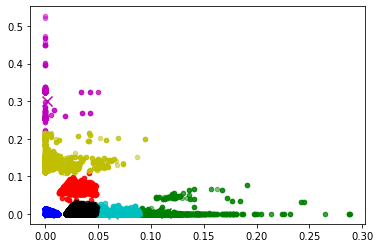

In [116]:
display_cluster(doc_topic,km,num_clusters)

In [1]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self   


In [3]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(cv_array)
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

NameError: name 'cv_array' is not defined